In [1]:
import gcsfs
from scipy.io import loadmat
from scipy.signal import resample
from scipy.stats import zscore
import matplotlib.pyplot as plt
import os.path as op
import numpy as np
from neurodsp.filt.filter import filter_signal

In [2]:
fs = gcsfs.GCSFileSystem(project='learning-2-learn-221016')

In [3]:
path = 'learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/'

In [4]:
data = np.empty((124, 11796177))

for chan in range(1, 125):
    fname = op.join(path, f'chan-{chan}', f'sub-SA_sess-20180918_chan-{chan}.mat')
    print(f"Opening {fname}")
    with fs.open(fname) as f_chan:
        f_chan = loadmat(f_chan)
        data[chan-1] = f_chan['data'].squeeze()

Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-1/sub-SA_sess-20180918_chan-1.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-2/sub-SA_sess-20180918_chan-2.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-3/sub-SA_sess-20180918_chan-3.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-4/sub-SA_sess-20180918_chan-4.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-5/sub-SA_sess-20180918_chan-5.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-6/sub-SA_sess-20180918_chan-6.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-7/sub-SA_sess-20180918_chan-7.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-8/sub-SA_sess-20180918_chan-8.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-9/sub-SA_sess-20180918_chan-9.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-10/sub-SA_sess

Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-80/sub-SA_sess-20180918_chan-80.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-81/sub-SA_sess-20180918_chan-81.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-82/sub-SA_sess-20180918_chan-82.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-83/sub-SA_sess-20180918_chan-83.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-84/sub-SA_sess-20180918_chan-84.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-85/sub-SA_sess-20180918_chan-85.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-86/sub-SA_sess-20180918_chan-86.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-87/sub-SA_sess-20180918_chan-87.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/chan-88/sub-SA_sess-20180918_chan-88.mat
Opening learning2learn/Buffalo/wcst-nhp/SA/sess-20180918/ephys/c

In [5]:
data = resample(data, data.shape[-1]//10, axis=-1)

In [6]:
from picard import picard

In [ ]:
K1, W1, Y1 = picard(data[:, :data.shape[-1]//2], n_components=n_components)
K2, W2, Y2 = picard(data[:, data.shape[-1]//2:], n_components=n_components)


In [8]:
def mixing(W, K):
    w = np.dot(W, K)
    return np.dot(w.T, np.linalg.inv(np.dot(w, w.T)))

In [181]:
corr = np.empty((mixing1.shape[-1], mixing2.shape[-1]))
for ii in range(corr.shape[0]):
    for jj in range(corr.shape[1]):
        corr[ii, jj] = np.abs(np.corrcoef(mixing1[:, ii], mixing2[:, jj])[0, 1])

In [182]:
new_mixing2 = np.empty_like(mixing2)

In [183]:
max_corr = np.zeros(mixing1.shape[-1])
for it in range(mixing1.shape[-1]):
    max_corr[it] = np.nanmax(corr)
    idx = np.where(corr == max_corr[it])
    new_mixing2[:, idx[0]] = mixing2[:, idx[1]]
    corr[idx[0], :] = np.nan
    corr[:, idx[1]] = np.nan

In [184]:
max_corr

array([0.99730399, 0.99241708, 0.88369501, 0.84257024, 0.80850632,
       0.78295636, 0.75350675, 0.58324904, 0.43461246, 0.0011602 ])

In [ ]:
new_mixing2

In [202]:
n_components = 3
mean_corr = [0]
break_it = False

while not break_it:   
    K1, W1, Y1 = picard(data[:, :data.shape[-1]//2], n_components=n_components)
    K2, W2, Y2 = picard(data[:, data.shape[-1]//2:], n_components=n_components)
    mixing1 = mixing(W1, K1)
    mixing2 = mixing(W2, K2)
    
    corr = np.empty((mixing1.shape[-1], mixing2.shape[-1]))
    for ii in range(corr.shape[0]):
        for jj in range(corr.shape[1]):
            corr[ii, jj] = np.abs(np.corrcoef(mixing1[:, ii], mixing2[:, jj])[0, 1])
    
    new_mixing2 = np.empty_like(mixing2)
    max_corr = np.zeros(mixing1.shape[-1])
    for it in range(mixing1.shape[-1]):
        max_corr[it] = np.nanmax(corr)
        idx = np.where(corr == max_corr[it])
        new_mixing2[:, idx[0]] = mixing2[:, idx[1]]
        corr[idx[0], :] = np.nan
        corr[:, idx[1]] = np.nan
   
    this_mean_corr = np.mean(max_corr)
    if this_mean_corr < mean_corr[-1] and (mean_corr[-1] - this_mean_corr) > 0.05 * mean_corr[-1]:
        mean_corr.append(this_mean_corr)
        break_it = True
    else:
        mean_corr.append(this_mean_corr)
    n_components = n_components + 1

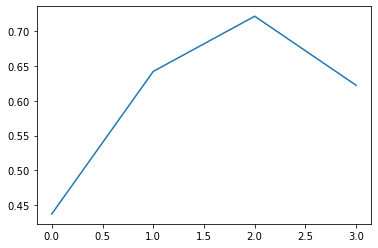

In [203]:
plt.plot(mean_corr[1:])

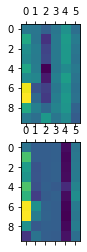

In [204]:
fig, ax = plt.subplots(2)
ax[0].matshow(new_mixing2[:10])
ax[1].matshow(mixing1[:10])